In [58]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime, timedelta
import re
import matplotlib.dates as mdates

## Read weekly data

In [59]:
start_date = date(2021, 10 ,27)
dates = [start_date+timedelta(x) for x in range(7,7*16,7)]
raw_data = pd.read_csv("weekly/evaluation_{}.csv".format(start_date.strftime("%Y%m%d")))

In [60]:
for date in dates:
    try:
        raw_data = raw_data.append(pd.read_csv("weekly/evaluation_{}.csv".format(date.strftime("%Y%m%d"))))
    except:
        print(date.strftime("%Y-%m-%d")+" Not available")

2021-12-29 Not available
2022-01-05 Not available


In [61]:
raw_data

,model,target,horizon,forecast_date,q0.025,q0.25,q0.5,q0.75,q0.975,value,qscore_q0.025,qscore_q0.25,qscore_q0.5,qscore_q0.75,qscore_q0.975,mean_qscore,ae,interval_coverage_0.5,interval_coverage_0.95,scores_imputed
0,AryaStark,DAX,1 day,2021-10-27,-2.294067,-0.422822,0.051950,0.540928,2.105637,-0.060375,0.111685,0.181223,0.112325,0.300651,0.108301,0.162837,0.112325,True,True,False
1,JabbaTheHutt,DAX,1 day,2021-10-27,-2.520820,-0.421760,0.075880,0.658580,2.093510,-0.060375,0.123022,0.180693,0.136255,0.359477,0.107694,0.181428,0.136255,True,True,False
2,DougJudy,DAX,1 day,2021-10-27,0.098211,0.098224,0.098231,0.098238,0.098250,-0.060375,0.309243,0.237898,0.158606,0.079306,0.007931,0.158597,0.158606,False,False,False
3,KyloRen,DAX,1 day,2021-10-27,-2.493657,-0.441905,0.084151,0.639838,2.230883,-0.060375,0.121664,0.190765,0.144526,0.350106,0.114563,0.184325,0.144526,True,True,False
4,HanSolo,DAX,1 day,2021-10-27,-1.842954,-0.568223,0.064408,0.764962,2.687890,-0.060375,0.089129,0.253924,0.124782,0.412668,0.137413,0.203583,0.124782,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,DAX_benchmark,temperature,84 hour,2022-02-09,NaN,NaN,NaN,NaN,NaN,5.200000,NaN,NaN,NaN,NaN,NaN,1.168182,2.272500,False,False,True
416,JabbaTheHutt,temperature,84 hour,2022-02-09,NaN,NaN,NaN,NaN,NaN,5.200000,NaN,NaN,NaN,NaN,NaN,1.168182,2.272500,False,False,True
417,RossGeller,temperature,84 hour,2022-02-09,NaN,NaN,NaN,NaN,NaN,5.200000,NaN,NaN,NaN,NaN,NaN,1.168182,2.272500,False,False,True
418,wind_benchmark,temperature,84 hour,2022-02-09,NaN,NaN,NaN,NaN,NaN,5.200000,NaN,NaN,NaN,NaN,NaN,1.168182,2.272500,False,False,True


## Filter data

In [99]:
data = raw_data.loc[raw_data["model"] == "HanSolo"]
data["horizon"] = data["horizon"].apply(lambda x: re.findall(r'\d+', x)[0])
data = data.astype({"horizon":"float64"})
data["forecast_date"] = pd.to_datetime(data["forecast_date"])
data = data.reset_index().drop("index", axis = 1)

C:\Users\chris\AppData\Local\Temp/ipykernel_25016/3892431281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["horizon"] = data["horizon"].apply(lambda x: re.findall(r'\d+', x)[0])


# Dax evaluation

In [114]:
dax_data = data[data["target"] == "DAX"].copy()

In [115]:
for horizon in dax_data["horizon"].unique():
    dax_data.loc[dax_data["horizon"] == horizon, "forecast_date"] = dax_data.loc[dax_data["horizon"] == horizon, "forecast_date"] + timedelta(horizon)

In [116]:
def get_interval_plot(data):
    fig, axs = plt.subplots(figsize = (10,8))
    sns.lineplot(x = "forecast_date", y = "value", data = data, label = "True value")
    sns.lineplot(x = "forecast_date", y = "q0.5", data = data, label = "50% quantile")
    sns.lineplot(x = "forecast_date", y = "q0.025", data = data, color = "blue", label = "95% interval")
    sns.lineplot(x = "forecast_date", y = "q0.975", data = data, color = "blue")
    axs.fill_between(x = data["forecast_date"], y1 = data["q0.025"], y2 = data["q0.975"], alpha = 0.1, color = "blue")

    sns.lineplot(x = "forecast_date", y = "q0.25", data = data, color = "green", label = "50% interval")
    sns.lineplot(x = "forecast_date", y = "q0.75", data = data, color = "green")
    axs.fill_between(x = data["forecast_date"], y1 = data["q0.25"], y2 = data["q0.75"], alpha = 0.1, color = "green")
    axs.legend()

In [192]:
def get_error_plot(data, method):
    fig, axs = plt.subplots(figsize = (15,10))
    sns.lineplot(x = "forecast_date", y = "mean_qscore", data = data[data["forecast_date"] <= "2021-12-22"], color = "tab:blue")
    sns.lineplot(x = "forecast_date", y = "mean_qscore", data = data[data["forecast_date"] > "2021-12-22"],color = "tab:blue")
    sns.scatterplot(x = "forecast_date", y = "mean_qscore", data = data, hue = "scores_imputed")
    axs.legend(title = "Forecast missing", fontsize = 16, title_fontsize = 16)
    axs.set_xlabel("Forecast date", fontsize = 20)
    axs.set_ylabel("Mean Quantile Score", fontsize = 20)
    axs.set_title("Performance of the {} model".format(method), fontsize = 20)
    plt.savefig("{}_performance.pdf".format(method), dpi = 300, bbox_inches = "tight")

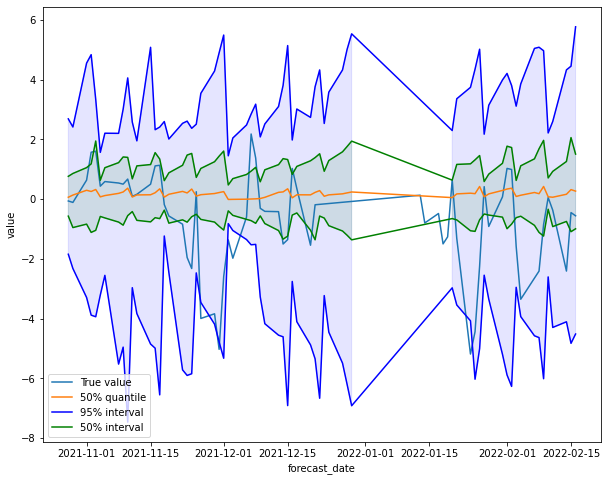

In [187]:
get_interval_plot(dax_data)

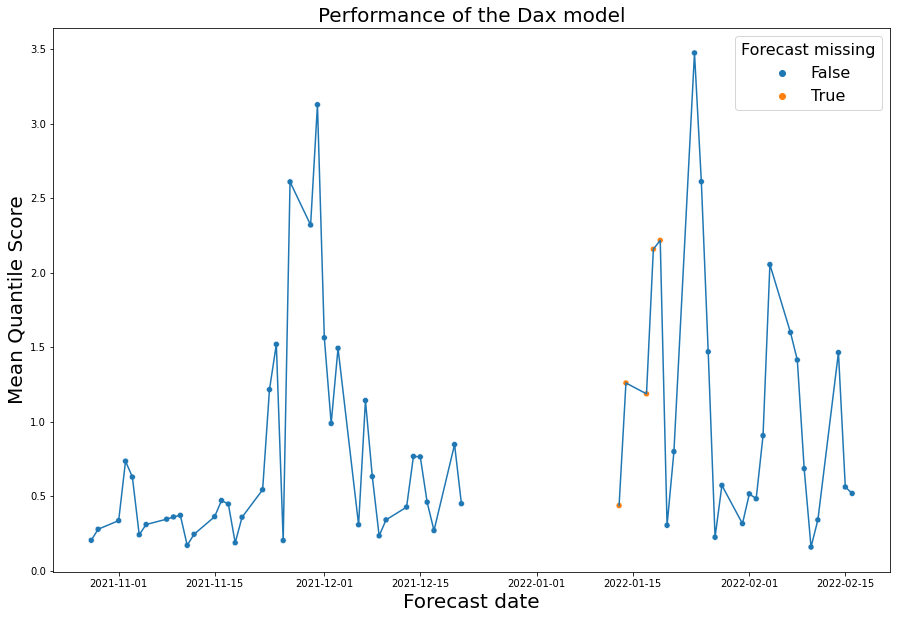

In [215]:
get_error_plot(dax_data, "Dax")

# Wind evaluation

In [189]:
wind_data = data[data["target"] == "wind"].copy()
for horizon in wind_data["horizon"].unique():
    wind_data.loc[wind_data["horizon"] == horizon, "forecast_date"] = wind_data.loc[wind_data["horizon"] == horizon, "forecast_date"] + timedelta(hours = horizon)

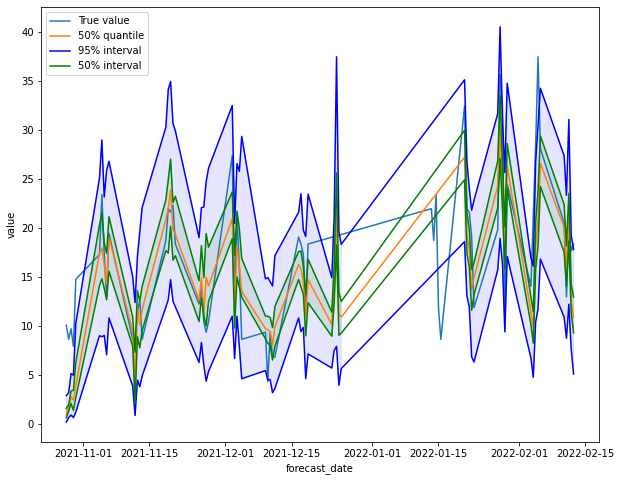

In [190]:
get_interval_plot(wind_data)

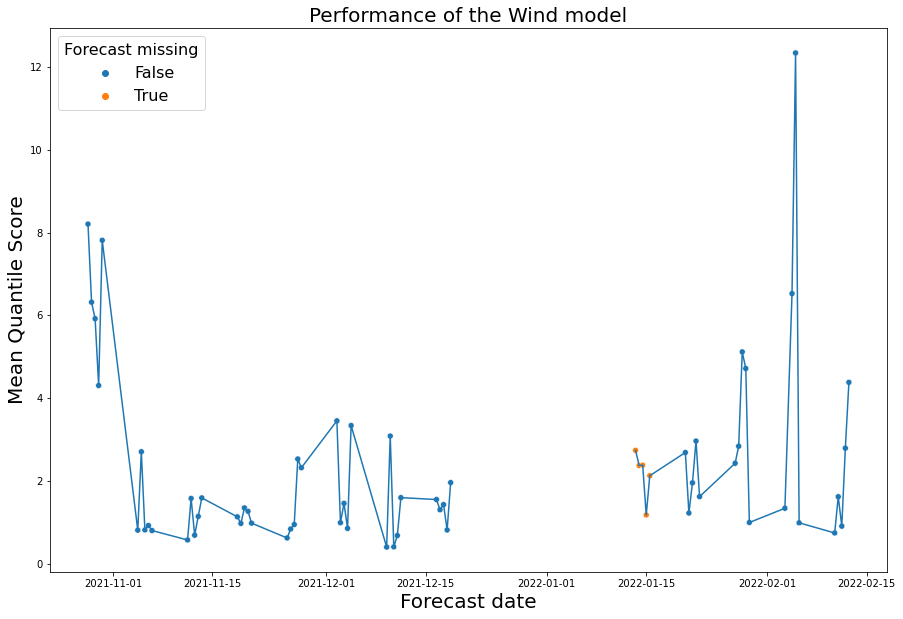

In [193]:
get_error_plot(wind_data, "Wind")

# Temperature evaluation

In [194]:
temp_data = data[data["target"] == "temperature"].copy()
for horizon in temp_data["horizon"].unique():
    temp_data.loc[temp_data["horizon"] == horizon, "forecast_date"] = temp_data.loc[temp_data["horizon"] == horizon, "forecast_date"] + timedelta(hours = horizon)

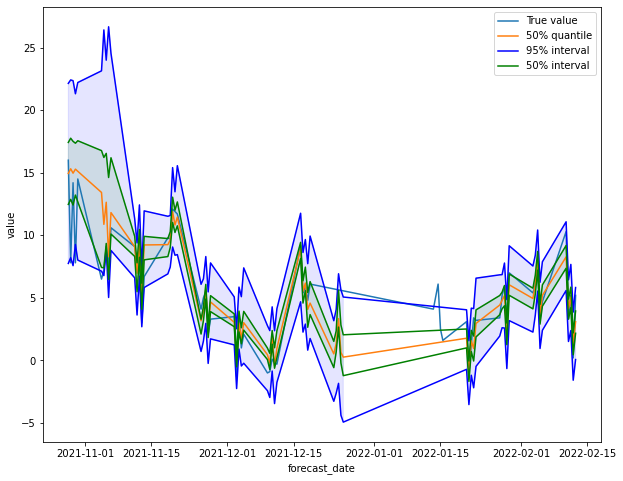

In [195]:
get_interval_plot(temp_data)

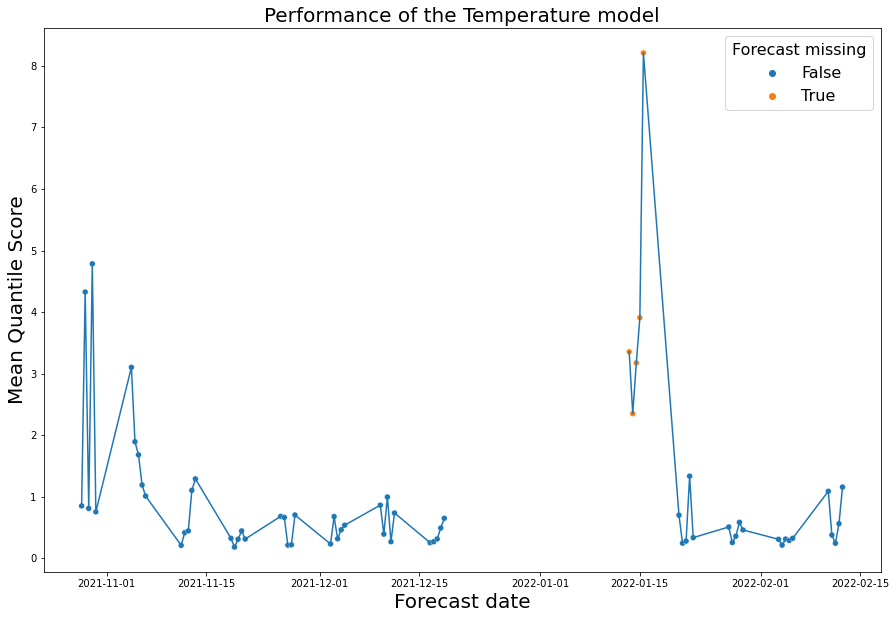

In [196]:
get_error_plot(temp_data, "Temperature")